# Keras LSTM Classification model

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

setup_notebook()

In [2]:
from datasets.stocks_data_wrapper import StocksDataWrapper
from helpers.data_helper import *
from helpers.plots_helper import *

In [12]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'GOOG'
price_column = 'Close'
project_label='KerasLSTMClassification'

predict_n = 5

THRESH_DIFF = 0.005

In [13]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", thresh_diff=THRESH_DIFF,
                                           compute_features=True, predict_n=predict_n, normalize=True)

data_wrapper.head()

,Date,Open,High,Low,Close,Volume,Adjusted,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,2007-02-21,0.060976,0.060866,0.064614,0.064011,0.242089,0.064011,0.016911,0.433593,0.009099,...,0.057511,0.057771,0.056349,0.581840,0.462882,0.541105,0.392573,higher,0.056271,stay
1,2007-02-22,0.063578,0.062483,0.066563,0.064008,0.246524,0.064008,0.011757,0.433481,0.011394,...,0.057686,0.057418,0.056519,0.580973,0.458111,0.533703,0.367303,stay,0.055913,stay
2,2007-02-23,0.062714,0.060363,0.064631,0.062475,0.166584,0.062475,0.022709,0.375610,0.000403,...,0.057673,0.057153,0.056455,0.573359,0.455835,0.523453,0.332589,lower,0.053115,lower
3,2007-02-26,0.061855,0.059868,0.063444,0.060808,0.170334,0.060808,0.009503,0.318246,0.008897,...,0.057764,0.056684,0.056171,0.566155,0.450778,0.522550,0.329110,lower,0.053780,higher
4,2007-02-27,0.056611,0.055376,0.058584,0.056072,0.399807,0.056072,0.012885,0.189966,0.039978,...,0.057480,0.056021,0.055274,0.546148,0.447407,0.501991,0.257379,lower,0.058645,higher


## Prepare data

In [14]:
y_column = 'Next'
seq_len = 5
n_splits=5
val_size = 0.2

features = ['Volume', 'Close', 'LowLen', 'Difference', 'SMA(20) - SMA(10)', 'BG_H_Band_Indicator', 'MACD']
datasets_splits = data_wrapper.get_datasets(n_splits=n_splits, val_size=val_size, sequences=True, seq_len=5, y_column=y_column, features_list=features)

datasets_splits.shape

(5, 6)

<AxesSubplot:>

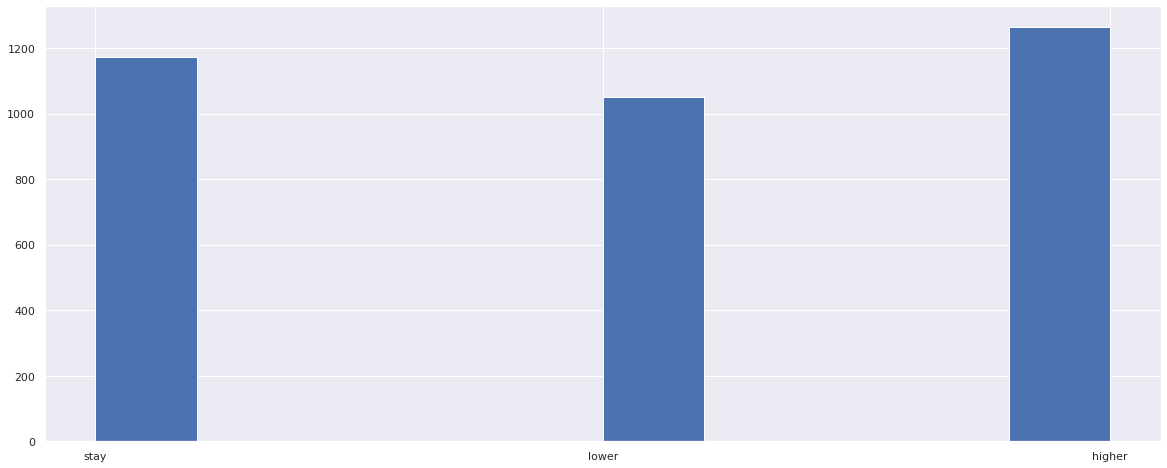

In [15]:
data_wrapper[y_column].hist()

## Model 

In [16]:
from keras.preprocessing import timeseries_dataset_from_array as build_timeseries_ds
from trainers.keras_classification_trainer import KerasClassificationTrainer
from models.keras_lstm_model import LSTMModel
import tensorflow as tf


config_dict = dict(
    quotation=quotation,
    predict_n = predict_n,
    features=features,
    learning_rate = 0.01,
    batch_size = 32,
    sequence_length=seq_len,
    n_epochs = 10,
    n_splits = n_splits,
    val_size = val_size,
)

group_name = f"[{quotation}] {seq_len}-sequences : {len(features)} features  -> predict:{predict_n}, {n_splits} splits {val_size} val"


for split_id, split in tqdm(enumerate(datasets_splits)):
    #run = wandb.init(project='StockRegressionKerasLSTM', config=config_dict, group=group_name, name=f"Split {split_id+1}")
    
    (X_train, X_val, X_test, y_train, y_val, y_test) = split
    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(config_dict['batch_size'])
    val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(config_dict['batch_size'])
    test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(config_dict['batch_size'])

    model = LSTMModel(config_dict, seq_len, len(features), output_dim=len(np.unique(y_train)),
                      learning_rate=config_dict['learning_rate'], loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    trainer = KerasClassificationTrainer(model, project_label=project_label)
    trainer.train(train_set, val_set)

0it [00:00, ?it/s]

Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMClassification/runs/24q1dvsl
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMClassification/runs/3t095hw6
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMClassification/runs/e9aj87ne
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMClassification/runs/4caj754m
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMClassification/runs/vj01hsns


### Train model with full training set (train + validation) and test on test set

In [17]:
config_dict['n_epochs'] = 150

full_train_set = train_set.concatenate(val_set)
final_model = LSTMModel(config_dict, seq_len, len(features), output_dim=len(np.unique(y_train)),learning_rate=config_dict['learning_rate'], loss='mse')
trainer = KerasClassificationTrainer(model, project_label=f"{project_label} full training-set")
trainer.train(full_train_set, val_set=test_set)

Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMClassification%20full%20training-set/runs/10cersgx


{'accuracy': 0.3931034482758621,
 'f1_score': 0.22185046090815974,
 'confusion_matrix': <wandb.sdk.data_types.Image at 0x20e99f083c8>}

<AxesSubplot:xlabel='Predictions', ylabel='True labels'>

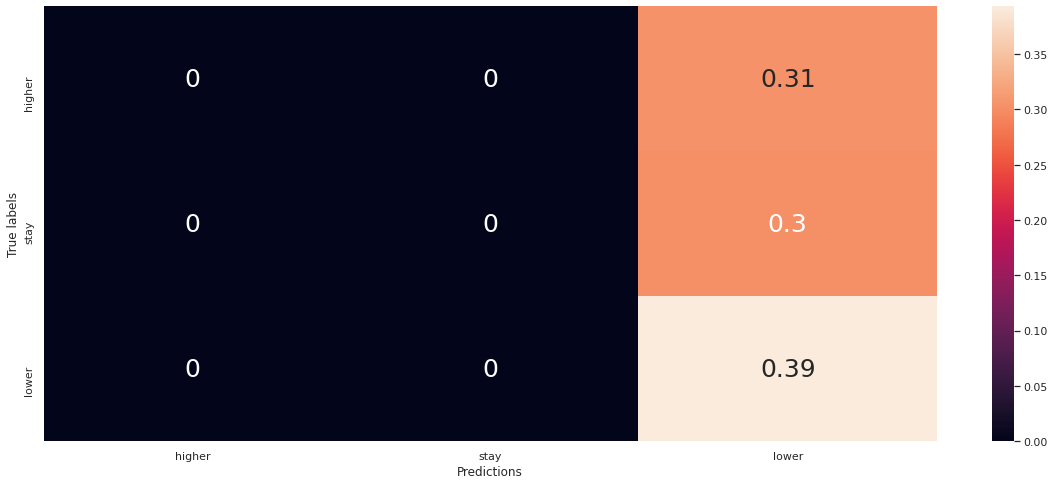

In [19]:
from helpers.plots_helper import plot_heatmap

predictions, labels = trainer.predict(test_set)
predictions = predictions.argmax(axis=1)
plot_heatmap(labels=labels, predictions=predictions, class_labels=['higher', 'stay', 'lower'])